## загрузка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle
from sklearn import metrics

In [13]:
data = pd.read_parquet('train.parquet')

## первичный осмотр

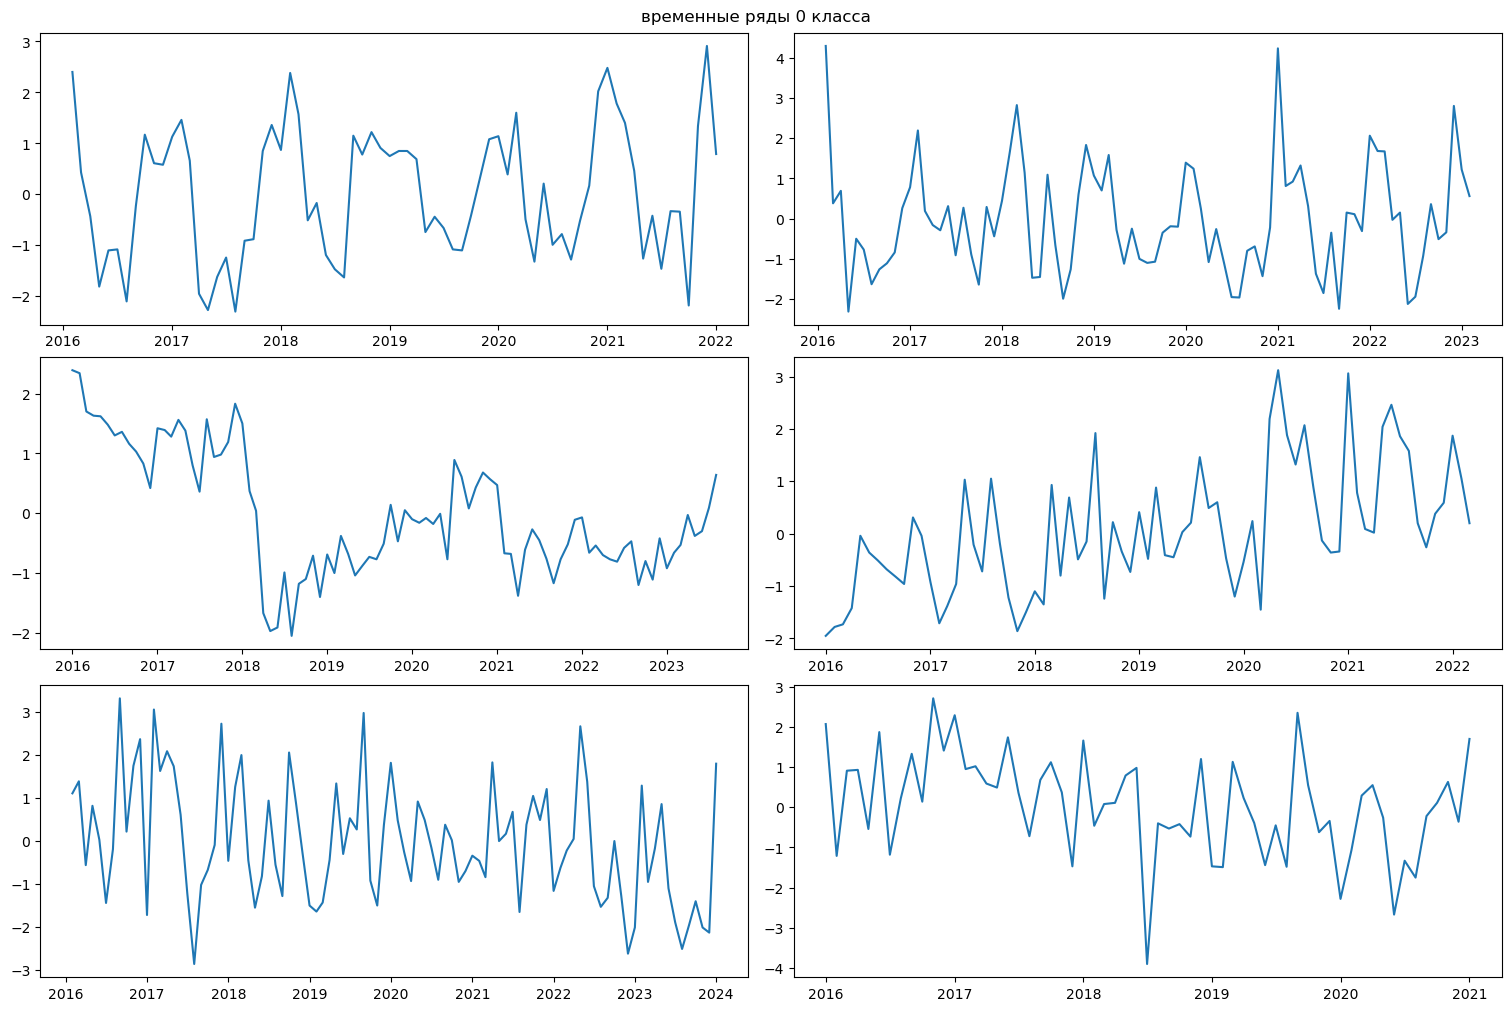

In [5]:
data_class_0 = data[data['label'] == 0][:100]
x_size = 2
y_size = 3
bias = 50
fig, axes = plt.subplots(y_size,x_size,figsize = (15,10),layout='constrained')
plt.suptitle('временные ряды 0 класса')
for i in range(y_size):
    for j in range(x_size):
        axes[i][j].plot(data_class_0.iloc[i*x_size + j + bias,1],data_class_0.iloc[i*x_size + j + bias,2])

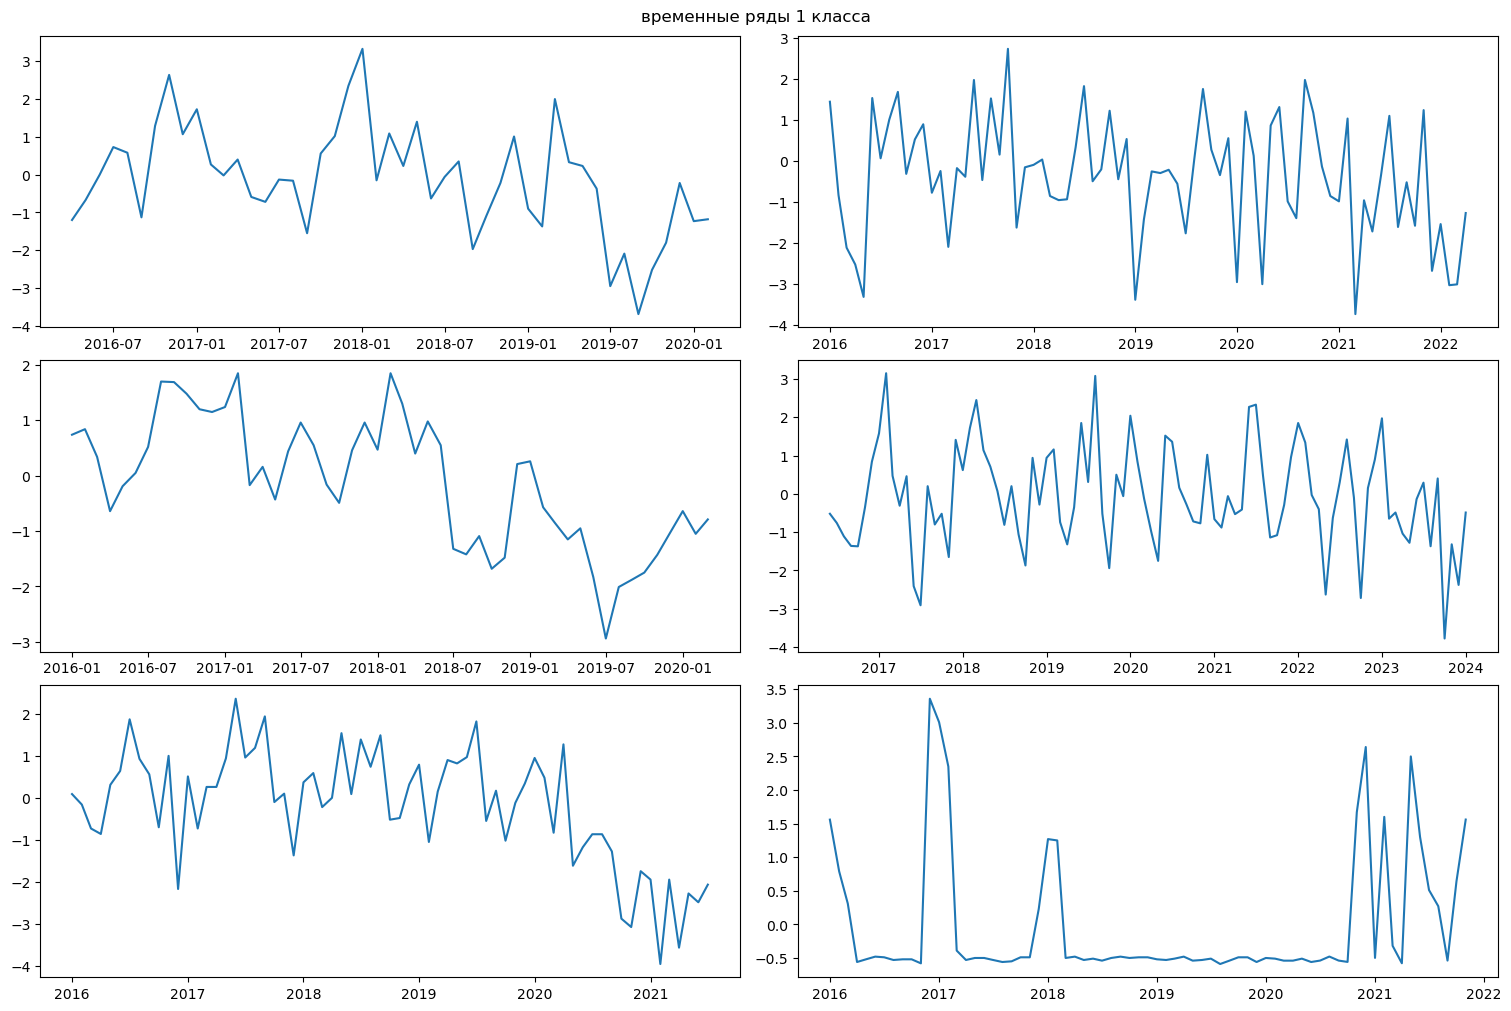

In [6]:
data_class_1 = data[data['label'] == 1][:100]
x_size = 2
y_size = 3
bias = 60
fig, axes = plt.subplots(y_size,x_size,figsize = (15,10),layout='constrained')
plt.suptitle('временные ряды 1 класса')
for i in range(y_size):
    for j in range(x_size):
        axes[i][j].plot(data_class_1.iloc[i*x_size + j + bias,1],data_class_1.iloc[i*x_size + j + bias,2])

по графикам рядов тяжело выделить какието отличия между класами стоит поробовать добавить новые признаки и работать уже с ними можно заметить что ряды имеют сильные колебания имеют разный разброс значений value, длину, дисперсию, кажеться что ряды первого класса снижаються к концу это все можно расмотреть как новые признаки.

## обработка данных
оставляем только те строки, где списки в values не содержат NaN

In [9]:
mask = data['values'].apply(lambda x: not any(np.isnan(i) for i in x))
data_filtred = data[mask]
dif = data['values'].size - data_filtred['values'].size
data_nan = data[~mask]
data_filtred = data_filtred.reset_index(drop=True)
print(f'было удалено {dif} элементов')

было удалено 88 элементов


посмотрим к какому классу чаще принадлежат удаленные данные

In [12]:
data_nan['label'].mean()

0.6022727272727273

в дальнейшем можно считать что все удаленные данные принадлежат классу 1 с вероятностью 0.6

# проверка гипотез
будут расматриваться только потвердившиеся гипотезы

## гипотеза о корреляции среднего, дисперсии и label
Сначала попробуем проверить корреляцию целевой переменной с распостранеными признаками.

h0 - предположим что нет корреляции между среднем, дисперсией и целевой переменой

h1 - корреляция есть

In [17]:
hypothesis_data = pd.DataFrame({'mean': np.empty(data_filtred['dates'].size),
                               'variance': np.empty(data_filtred['dates'].size),
                               'label': data_filtred['label'].values})

for i in range(data_filtred['dates'].size):
    #количество месяцев прошедших с самой ранней даты начала ряда
    hypothesis_data.loc[i,'variance'] = data_filtred['values'][i].var()
    hypothesis_data.loc[i,'mean'] = data_filtred['values'][i].mean()
    

In [18]:
fiture_columns = hypothesis_data.drop(columns=['label']).columns
# Вычисление корреляции Спирмена для каждого признака
for column in fiture_columns:
    corr, p_value = spearmanr(hypothesis_data[column], hypothesis_data['label'])
    print(f"Корреляция Спирмена между {column} и целевой переменной: {corr:.4f}, p-value: {p_value:.4f}")

Корреляция Спирмена между mean и целевой переменной: -0.4732, p-value: 0.0000
Корреляция Спирмена между variance и целевой переменной: 0.0512, p-value: 0.0000


### результат
h0 отвергаеться оба признака имеют статистическую значимость 

заметна сильная кореляция между средним и label

## гипотеза о корреляции квантилей и label
возможно имеет значение распределение values для того чтобы это проверить расмотрим его квантили.

h0 - предположим что нет корреляции между значением квантиля и целевой переменой

h1 - корреляция есть

In [21]:
quantiles = [0.1,0.3,0.5,0.7,0.9]
hypothesis_data = pd.DataFrame({'label': data_filtred['label'].values})
for i in quantiles:
    hypothesis_data[f'quantile_{i}'] = np.empty(data_filtred['dates'].size)

for i in range(data_filtred['dates'].size):
    for j in quantiles:
        hypothesis_data.loc[i,f'quantile_{j}'] = np.quantile(np.array(data_filtred.loc[i,'values']), j)


In [22]:
fiture_columns = hypothesis_data.drop(columns=['label']).columns
for column in fiture_columns:
    corr, p_value = spearmanr(hypothesis_data[column], hypothesis_data['label'])
    print(f"Корреляция Спирмена между {column} и целевой переменной: {corr:.4f}, p-value: {p_value:.4f}")

Корреляция Спирмена между quantile_0.1 и целевой переменной: -0.1851, p-value: 0.0000
Корреляция Спирмена между quantile_0.3 и целевой переменной: -0.2573, p-value: 0.0000
Корреляция Спирмена между quantile_0.5 и целевой переменной: -0.2715, p-value: 0.0000
Корреляция Спирмена между quantile_0.7 и целевой переменной: -0.2264, p-value: 0.0000
Корреляция Спирмена между quantile_0.9 и целевой переменной: -0.1557, p-value: 0.0000


### результат
h0 отвергаеться для всех квантилей они имеют статистическую значимость. 

Можно предположить что распределение values имеет значение. 

## гипотеза о корреляции суммы элементов в разных четвертях с label
проверим что график снижаеться к концу для этого посмотрим на суммы элементов в его четвертях

h0 - нет кореляции между суммой элементов в четвертях и label

h1 - она есть

In [20]:
def sum_off_quarters(arr):
    #возвращяет массив из 3 элементов 1 сумма элементов в 1 четверти 2 сума 2 и 3 четверти 3 сумма 4 четверти
    if len(arr) < 4:
        return [0,sum(arr),0]
    
    quarter_len = len(arr) // 4
    first_quarter = sum(arr[:quarter_len])
    last_quarter = sum(arr[-quarter_len:])                     
    mid = sum(arr) - first_quarter - last_quarter
    
    return [first_quarter,mid,last_quarter]

In [27]:
hypothesis_data = pd.DataFrame({'first_quarter': np.empty(data_filtred['dates'].size),
                               'two_mid_quarter': np.empty(data_filtred['dates'].size),
                                'last_quarter': np.empty(data_filtred['dates'].size),
                               'label': data_filtred['label'].values})

for i in range(data_filtred['dates'].size):
    quarters = sum_off_quarters(data_filtred['values'][i])
    hypothesis_data.loc[i,'first_quarter'] = quarters[0]
    hypothesis_data.loc[i,'two_mid_quarter'] = quarters[1]
    hypothesis_data.loc[i,'last_quarter'] =  quarters[2]

In [28]:
fiture_columns = hypothesis_data.drop(columns=['label']).columns
# Вычисление корреляции Спирмена для каждого признака
for column in fiture_columns:
    corr, p_value = spearmanr(hypothesis_data[column], hypothesis_data['label'])
    print(f"Корреляция Спирмена между {column} и целевой переменной: {corr:.4f}, p-value: {p_value:.4f}")

Корреляция Спирмена между first_quarter и целевой переменной: 0.0633, p-value: 0.0000
Корреляция Спирмена между two_mid_quarter и целевой переменной: 0.0331, p-value: 0.0000
Корреляция Спирмена между last_quarter и целевой переменной: -0.4176, p-value: 0.0000


### результат
h0 отвергаеться для всех признаков они имеют статистическую значимость

можно заметить что label имеет сильную отрицательную кореляцию с суммой элементов в последней четверти а значит графики 1 класса действительно имеют меньшый правый хвост чем графики 0 класса

## гипотеза о корреляции рядов фурье с label
в данных заметны сильные цекличные колебания можно поробовать найти члены рядов фурье 

h0 - нет корреляции между членами рядов фурье и label

h1 - корреляция есть

In [32]:
for i in range(3):  # Для первых трех коэффициентов
    hypothesis_data = pd.DataFrame({f'angle_coeff_{i}': np.empty(data_filtred['dates'].size),
                                f'abs_coeff_{i}': np.empty(data_filtred['dates'].size),
                               f'real_coeff_{i}': np.empty(data_filtred['dates'].size),})
                                    
# Перебираем строки DataFrame
for i, row in data_filtred.iterrows():
    # Применение дискретного преобразования Фурье к значениями временного ряда
    fft_coefficients = np.fft.fft(row['values'])
    
    for j in range(3):  # Для первых трех коэффициентов      
        hypothesis_data.loc[i,f'angle_coeff_{j}'] = np.angle(fft_coefficients[j])
        hypothesis_data.loc[i,f'abs_coeff_{j}'] = np.abs(fft_coefficients[j])
        hypothesis_data.loc[i,f'real_coeff_{j}'] = np.real(fft_coefficients[j])
        
hypothesis_data['label'] = data_filtred.label

In [33]:
fiture_columns = hypothesis_data.drop(columns=['label']).columns
# Вычисление корреляции Спирмена для каждого признака
for column in fiture_columns:
    corr, p_value = spearmanr(hypothesis_data[column], hypothesis_data['label'])
    print(f"Корреляция Спирмена между {column} и целевой переменной: {corr:.4f}, p-value: {p_value:.4f}")

Корреляция Спирмена между angle_coeff_2 и целевой переменной: -0.2105, p-value: 0.0000
Корреляция Спирмена между abs_coeff_2 и целевой переменной: 0.1426, p-value: 0.0000
Корреляция Спирмена между real_coeff_2 и целевой переменной: -0.1188, p-value: 0.0000
Корреляция Спирмена между angle_coeff_0 и целевой переменной: 0.3688, p-value: 0.0000
Корреляция Спирмена между abs_coeff_0 и целевой переменной: 0.2620, p-value: 0.0000
Корреляция Спирмена между real_coeff_0 и целевой переменной: -0.4714, p-value: 0.0000
Корреляция Спирмена между angle_coeff_1 и целевой переменной: -0.1838, p-value: 0.0000
Корреляция Спирмена между abs_coeff_1 и целевой переменной: 0.1586, p-value: 0.0000
Корреляция Спирмена между real_coeff_1 и целевой переменной: -0.2550, p-value: 0.0000


### результат
h0 отвергаеться для всех признаков они имеют статистическую значимость 

следовательно можно сделать вывод что колебания ряда влияют на его класс

# Исследование корреляций между переменными
в процесе генирации признаков могли получиться признаки с сильной корреляцией между собой и чтобы уменьшить количество признаков и вероятность переобучения удалим такие признаки

In [36]:
def generated_features(data):
    #функция для генерации всех новых признаков
    
    mask = data['values'].apply(lambda x: not any(np.isnan(i) for i in x))
    data_filtred = data[mask]
    dif = data['values'].size - data_filtred['values'].size
    data_nan = data[~mask]
    data_filtred = data_filtred.reset_index(drop=True)

    data_processed = pd.DataFrame({'id': data_filtred.id.values,
                                'label': data_filtred.label.values,
                                'mean': np.empty(data_filtred['dates'].size),
                               'variance': np.empty(data_filtred['dates'].size),})

    for i in range(data_filtred['dates'].size):
        data_processed.loc[i,'variance'] = data_filtred['values'][i].var()
        data_processed.loc[i,'mean'] = data_filtred['values'][i].mean()
    
    for i in range(3):  # Для первых трех коэффициентов
        data_processed[f'angle_coeff_{i}'] = np.empty(data_filtred['dates'].size)
        data_processed[f'abs_coeff_{i}'] = np.empty(data_filtred['dates'].size)
        data_processed[f'real_coeff_{i}'] = np.empty(data_filtred['dates'].size)
        
    for i, row in data_filtred.iterrows():
        # Применение дискретного преобразования Фурье к значениями временного ряда
        fft_coefficients = np.fft.fft(row['values'])
    
        for j in range(3):  # Для первых трех коэффициентов      
            data_processed.loc[i,f'angle_coeff_{j}'] = np.angle(fft_coefficients[j])
            data_processed.loc[i,f'abs_coeff_{j}'] = np.abs(fft_coefficients[j])
            data_processed.loc[i,f'real_coeff_{j}'] = np.real(fft_coefficients[j])
    quantiels = [0.1,0.3,0.5,0.7,0.9]
    for i in quantiels:
        data_processed[f'quantile_{i}'] = np.empty(data_filtred['dates'].size)

    for i in range(data_filtred['dates'].size):
        for j in quantiels:
            data_processed.loc[i,f'quantile_{j}'] = np.quantile(np.array(data_filtred.loc[i,'values']), j)
    
    quater_features = ['first_quarter','two_mid_quarter','last_quarter']
    for i in quater_features:
        data_processed[i] = np.empty(data_filtred['dates'].size)
        
    for i in range(data_filtred['dates'].size):
        quarters = sum_off_quarters(data_filtred['values'][i])
        data_processed.loc[i,'first_quarter'] = quarters[0]
        data_processed.loc[i,'two_mid_quarter'] = quarters[1]
        data_processed.loc[i,'last_quarter'] =  quarters[2]

    return data_processed

In [37]:
data_processed = generated_features(data_filtred)

In [38]:
data_processed.corr()

,id,label,mean,variance,angle_coeff_0,abs_coeff_0,real_coeff_0,angle_coeff_1,abs_coeff_1,real_coeff_1,...,abs_coeff_2,real_coeff_2,quantile_0.1,quantile_0.3,quantile_0.5,quantile_0.7,quantile_0.9,first_quarter,two_mid_quarter,last_quarter
id,1.000000,0.000866,-0.001920,0.001749,-0.001640,0.003260,-0.002377,0.003201,0.000775,-0.001904,...,0.000502,-0.000674,-0.004156,-0.003209,0.000733,0.000632,0.001365,-0.002026,-0.000467,0.000632
label,0.000866,1.000000,-0.478798,0.066935,0.365393,0.310683,-0.474207,-0.160666,0.147893,-0.251055,...,0.143288,-0.124101,-0.156447,-0.252734,-0.270071,-0.214785,-0.152257,0.060751,0.039434,-0.410526
mean,-0.001920,-0.478798,1.000000,-0.144464,-0.706560,-0.446560,0.968760,0.111136,-0.020463,0.151752,...,-0.038745,0.047684,0.397508,0.576069,0.511291,0.348210,0.245725,0.113740,0.254578,0.338509
variance,0.001749,0.066935,-0.144464,1.000000,0.034486,0.322680,-0.135007,-0.108375,-0.258006,-0.169459,...,-0.083863,-0.058969,-0.710049,-0.457261,0.079445,0.433906,0.544148,-0.011287,0.099577,-0.165318
angle_coeff_0,-0.001640,0.365393,-0.706560,0.034486,1.000000,0.170255,-0.717041,-0.065963,0.045519,-0.101880,...,0.049812,-0.042850,-0.232870,-0.378079,-0.374226,-0.283416,-0.214975,-0.078809,-0.199191,-0.246383
abs_coeff_0,0.003260,0.310683,-0.446560,0.322680,0.170255,1.000000,-0.450055,-0.094197,-0.080502,-0.161310,...,-0.007501,-0.060482,-0.405580,-0.369677,-0.146821,0.030316,0.077702,-0.053531,-0.032617,-0.228911
real_coeff_0,-0.002377,-0.474207,0.968760,-0.135007,-0.717041,-0.450055,1.000000,0.104305,-0.039779,0.156822,...,-0.061579,0.063431,0.384252,0.557564,0.496152,0.337609,0.237268,0.117360,0.263656,0.348735
angle_coeff_1,0.003201,-0.160666,0.111136,-0.108375,-0.065963,-0.094197,0.104305,1.000000,-0.065403,0.070735,...,-0.037220,0.006385,0.115673,0.078760,0.023834,-0.017818,-0.017357,-0.479511,-0.056525,0.556620
abs_coeff_1,0.000775,0.147893,-0.020463,-0.258006,0.045519,-0.080502,-0.039779,-0.065403,1.000000,-0.051436,...,0.274735,-0.034070,0.084531,-0.015590,-0.057032,-0.013559,-0.027318,0.113395,0.046473,-0.169822
real_coeff_1,-0.001904,-0.251055,0.151752,-0.169459,-0.101880,-0.161310,0.156822,0.070735,-0.051436,1.000000,...,-0.007091,0.065214,0.281297,0.088592,-0.129658,-0.153441,0.004254,0.441050,-0.862658,0.431394


большое значение корреляции 0.96 замечена между mean и real_coeff_0 следует удалить признак real_coeff_0 тк у mean чуть большея корреляция с label

In [8]:
def generated_features_without_corr(data):
    #функция для генерации всех новых признаков без сильной корреляции
    
    mask = data['values'].apply(lambda x: not any(np.isnan(i) for i in x))
    data_filtred = data[mask]
    dif = data['values'].size - data_filtred['values'].size
    data_nan = data[~mask]
    data_filtred = data_filtred.reset_index(drop=True)

    data_processed = pd.DataFrame({'id': data_filtred.id.values,
                                'label': data_filtred.label.values,
                                'mean': np.empty(data_filtred['dates'].size),
                               'variance': np.empty(data_filtred['dates'].size),})

    for i in range(data_filtred['dates'].size):
        data_processed.loc[i,'variance'] = data_filtred['values'][i].var()
        data_processed.loc[i,'mean'] = data_filtred['values'][i].mean()
    
    for i in range(3):  # Для первых трех коэффициентов
        data_processed[f'angle_coeff_{i}'] = np.empty(data_filtred['dates'].size)
        data_processed[f'abs_coeff_{i}'] = np.empty(data_filtred['dates'].size)
        if i != 0:
            data_processed[f'real_coeff_{i}'] = np.empty(data_filtred['dates'].size)
        
    for i, row in data_filtred.iterrows():
        # Применение дискретного преобразования Фурье к значениями временного ряда
        fft_coefficients = np.fft.fft(row['values'])
    
        for j in range(3):  # Для первых трех коэффициентов      
            data_processed.loc[i,f'angle_coeff_{j}'] = np.angle(fft_coefficients[j])
            data_processed.loc[i,f'abs_coeff_{j}'] = np.abs(fft_coefficients[j])
            if j != 0:
                data_processed.loc[i,f'real_coeff_{j}'] = np.real(fft_coefficients[j])
    quantiels = [0.1,0.3,0.5,0.7,0.9]
    for i in quantiels:
        data_processed[f'quantile_{i}'] = np.empty(data_filtred['dates'].size)

    for i in range(data_filtred['dates'].size):
        for j in quantiels:
            data_processed.loc[i,f'quantile_{j}'] = np.quantile(np.array(data_filtred.loc[i,'values']), j)
    
    quater_features = ['first_quarter','two_mid_quarter','last_quarter']
    for i in quater_features:
        data_processed[i] = np.empty(data_filtred['dates'].size)
        
    for i in range(data_filtred['dates'].size):
        quarters = sum_off_quarters(data_filtred['values'][i])
        data_processed.loc[i,'first_quarter'] = quarters[0]
        data_processed.loc[i,'two_mid_quarter'] = quarters[1]
        data_processed.loc[i,'last_quarter'] =  quarters[2]

    return data_processed, data_nan

# построение модели
построим модель random_forest тк она может предсказывать вероятность принадлежности классу, может находить сложные закономерности в данных, менее склона к переобучению

In [22]:
data_processed, data_nan = generated_features_without_corr(data)
fiture_columns = data_processed.columns[(data_processed.columns != 'label') & (data_processed.columns != 'id')]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data_processed[fiture_columns], data_processed.label, test_size=0.10, random_state=42)

In [78]:
model_RF = RandomForestClassifier(n_estimators=150,max_depth=10, max_features=6).fit(X_train, y_train)

In [79]:
print('отчет о результате работы модели на обучающей выборке')
print(classification_report(y_train,model_RF.predict(X_train)))

отчет о результате работы модели на обучающей выборке
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92     51965
         1.0       0.87      0.68      0.76     19955

    accuracy                           0.88     71920
   macro avg       0.88      0.82      0.84     71920
weighted avg       0.88      0.88      0.88     71920



In [80]:
print('отчет о результате работы модели на тестовых данных')
print(classification_report(y_test,model_RF.predict(X_test)))

отчет о результате работы модели на тестовых данных
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      5820
         1.0       0.79      0.61      0.68      2172

    accuracy                           0.85      7992
   macro avg       0.82      0.77      0.79      7992
weighted avg       0.84      0.85      0.84      7992



оценим ROC AUC этой модели

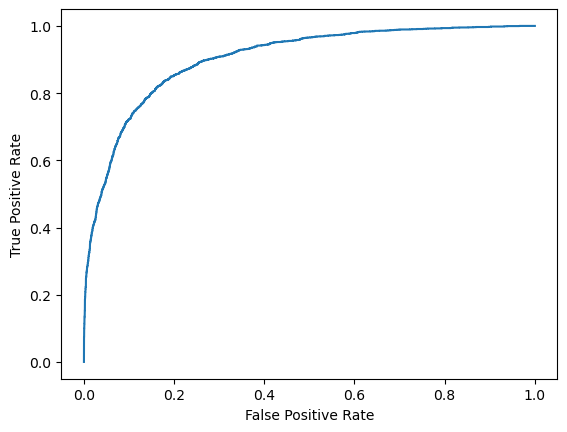

In [82]:
fpr, tpr, _ = metrics.roc_curve(y_test, model_RF.predict_proba(X_test)[:,1])

# построение ROC кривой
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [83]:
auc = metrics.roc_auc_score(y_test, model_RF.predict_proba(X_test)[:,1])
print("AUC: %.3f" % auc)

AUC: 0.903


### результат
получения модель имеет показатель ROC AUC = 0.903 обладает точнстью в 0.85 на тестовой выборке и 0.88 на обучающей

обучим такую же модель на всех данных

In [89]:
model_RF = RandomForestClassifier(n_estimators=150,max_depth=10, max_features=6).fit(data_processed[fiture_columns], data_processed.label)

In [90]:
with open("model_RF.pickle", "wb") as file:
    pickle.dump(model_RF, file)